In [83]:
#dataframes
import pandas as pd
import h5py

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math as m
from scipy.spatial.distance import cdist
import statsmodels.api as sm
import statsmodels.formula.api as smf

#plots
import pylab as plt
import matplotlib.pyplot as plt
import matplotlib as mat
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
import figurefirst

#misc
import time
np.set_printoptions(suppress=True)


In [160]:
# set_number = 5
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/LowRes/' #/Set0'+str(set_number)+'/'
# wind_load= 'Run0'+str(set_number)+'_expected_full.hdf' 
# wind_load = 'wind05Run03_InterpolatedX.hdf'
wind_load='NotWindy_Expected.h5'
windn = pd.read_hdf(dir+wind_load)

In [161]:
df=windn
df['time']=df.sync_time

In [162]:
## getting the indexes for odor over a threshold to determine each encounter
def get_index(df):
    idx = []
    for i in range(len(df.odor)):
        if (df.odor[i]>2):
            idx.append(df.index[i])

    from itertools import groupby
    from operator import itemgetter
    index = [ ]
    for k, g in groupby(enumerate(idx),lambda ix : ix[0] - ix[1]):
        index.append((list((map(itemgetter(1), g)))))
    return index

In [163]:
fdf=pd.DataFrame()
# fdf['master_time'] = df.master_time
index = get_index(df)
i = 0

#to compare with R^2 analysis
avg_dist_from_source = []
while i<len(index):
    avg_dist_from_source.append(np.mean(df.distance_along_streakline[index[i]]))
    i+=1
fdf['avg_dist_along_streakline']=avg_dist_from_source


i=0
avg_dist_source = []
while i<len(index):
    avg_dist_source.append(np.mean(df.distance_from_source[index[i]]))
    i+=1
fdf['avg_dist_from_source']=avg_dist_source

avg_dist_from_streakline = []
i = 0
while i<len(index):
    avg_dist_from_streakline.append(np.mean(df.nearest_from_streakline[index[i]]))
    i+=1
fdf['avg_dist_from_streakline']=avg_dist_from_streakline

rel_motion = []
i= 0
while i<len(index):
    rel_motion.append(np.mean(df.relative_motion[index[i]]))
    i+=1
fdf['avg_relative_motion']=rel_motion

In [164]:
# mean odor concentration
i = 0
concentration = []
while i<len(index):
    concentration.append(np.mean(df.odor[index[i]]))
    i+=1
fdf['odor'] = concentration

# time of the encounters
i = 0
length_of_encounter = []
dt = df.time[1]-df.time[0]   ## dt is constant, dt * length gives length of time
while i < len(index):
    length_of_encounter.append(dt*(len(index[i])))
    i+=1
fdf['length_of_encounter'] = length_of_encounter

#time between the encounters
i = 0
intermittency = []
while i < len(index):
    if i < (len(index)-1):
        intermittency.append((index[i+1][0] - index[i][-1])*dt)
        i+=1
    else:
        intermittency.append(0)
        i+=1
fdf['odor_intermittency'] = intermittency

## Trajectory speed during Intermittency
i = 0
speed_at_intermittency=[]
while i < len(index):
    if i < (len(index)-1):
        x = np.mean(df.gps_linear_x[index[i][-1]:index[i+1][0]])
        y = np.mean(df.gps_linear_y[index[i][-1]:index[i+1][0]])
        z = np.mean(df.gps_linear_z[index[i][-1]:index[i+1][0]])
        speed_at_intermittency.append(np.sqrt(x**2+y**2+z**2))
        i+=1
    else:
        speed_at_intermittency.append(0)
        i+=1

fdf['speed_at_intermittency'] = speed_at_intermittency

## Trajectory speed during Encounters
i = 0
speed_at_encounter=[]
while i < len(index):
        x = np.mean(df.gps_linear_x[index[i][0]:index[i][-1]])
        y = np.mean(df.gps_linear_y[index[i][0]:index[i][-1]])
        z = np.mean(df.gps_linear_z[index[i][0]:index[i][-1]])
        speed_at_encounter.append(np.sqrt(x**2+y**2+z**2))
        i+=1
fdf['speed_at_encounter'] = speed_at_encounter


## Odor Standard Deviation
i = 0
st_dev = []
while i<len(index):
    st_dev.append(np.std(df.odor[index[i]]))
    i+=1
fdf['odor_stdev'] = st_dev

## Trisonica Mean Pressure
i = 0
pressure = []
while i<len(index):
    pressure.append(np.mean(df.trisonica_pressure[index[i]]))
    i+=1
fdf['tri_pressure'] = pressure

## Trisonica Mean Temperature
i = 0
temperature = []
while i<len(index):
    temperature.append(np.mean(df.trisonica_temperature[index[i]]))
    i+=1
fdf['tri_temperature'] = temperature

## Trisonica Mean Linear acceleration
i = 0
linear_acc_x = []
while i<len(index):
    linear_acc_x.append(np.mean(df.imu_linear_acc_x[index[i]]))
    i+=1
fdf['linear_acc_x'] = linear_acc_x

i = 0
linear_acc_y = []
while i<len(index):
    linear_acc_y.append(np.mean(df.imu_linear_acc_y[index[i]]))
    i+=1
fdf['linear_acc_y'] = linear_acc_y

i = 0
linear_acc_z = []
while i<len(index):
    linear_acc_z.append(np.mean(df.imu_linear_acc_z[index[i]]))
    i+=1
fdf['linear_acc_z'] = linear_acc_z

## Trisonica Mean Angular vel
i = 0
angular_vel_x = []
while i<len(index):
    angular_vel_x.append(np.mean(df.imu_angular_x[index[i]]))
    i+=1
fdf['imu_angular_x'] = angular_vel_x

i = 0
angular_vel_y = []
while i<len(index):
    angular_vel_y.append(np.mean(df.imu_angular_y[index[i]]))
    i+=1
fdf['imu_angular_y'] = angular_vel_y

i = 0
angular_vel_z = []
while i<len(index):
    angular_vel_z.append(np.mean(df.imu_angular_z[index[i]]))
    i+=1
fdf['imu_angular_z'] = angular_vel_z



##TODO: more features

In [165]:
# #finding sensor motion relative to wind direction from stationery

# sensor_direction = np.array(np.arctan2(df.gps_linear_y,df.gps_linear_x)* 180 / np.pi)

# for i in range(len(sensor_direction)):
#     if (sensor_direction[i] <0.0): 
#         sensor_direction[i]+=360.0
#     else:
#         sensor_direction[i]=sensor_direction[i]

# fdf['relative_motion']=sensor_direction - df.D

In [172]:
fdf = pd.read_hdf(dir+'Windy_Stats.h5')

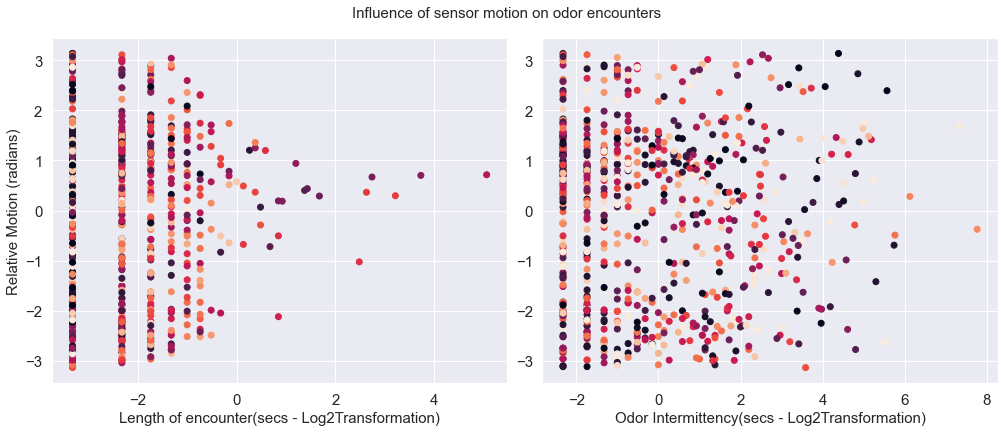

In [173]:
# f, (ax1,ax2) = plt.subplots(1,2, figsize =(14,6), gridspec_kw={'width_ratios': [4,4]})
# # ax1.set_xlim(0,10)
# ax1.scatter(np.log2(fdf.length_of_encounter), fdf.avg_relative_motion, c=fdf.odor)
# ax1.set_xlabel('Length of encounter(secs - Log2Transformation)')
# ax1.set_ylabel('Relative Motion (radians)')
# # ax2.set_xlim(0,50)
# ax2.scatter(np.log2(fdf.odor_intermittency), fdf.avg_relative_motion, c=fdf.odor)
# ax2.set_xlabel('Odor Intermittency(secs - Log2Transformation)')
# # ax2.set_ylabel('Speed During Intermittency (m/s)')
# f.suptitle('Influence of sensor motion on odor encounters')
# f.tight_layout()
# figurefirst.mpl_functions.set_fontsize(f, 15)
# f.savefig('../../trajspeed.jpeg')

In [136]:
## Normalization
# normalized_fdf=(fdf-fdf.mean())/fdf.std()

## mean max normalization
# normalized_fdf=(fdf-fdf.min())/(fdf.max()-fdf.min())
fdf.to_hdf(dir+'NotWindy_Stats.h5', key='df', mode='w')

In [46]:
# odor_distance_model = smf.ols(formula='avg_dist_fromsource ~ odor + odor_intermittency + length_of_encounter + odor_stdev + tri_pressure + tri_temperature + linear_acc_x + linear_acc_y + linear_acc_z + imu_angular_x + imu_angular_y + imu_angular_z', data=fdf).fit()
encounters=smf.ols(formula='avg_dist_fromsource~ odor+length_of_encounter+odor_intermittency+relative_motion+ odor_stdev + tri_pressure + tri_temperature', data=normalized_fdf).fit()
print(encounters.summary())

                             OLS Regression Results                            
Dep. Variable:     avg_dist_fromsource   R-squared:                       0.160
Model:                             OLS   Adj. R-squared:                  0.155
Method:                  Least Squares   F-statistic:                     30.83
Date:                 Thu, 29 Apr 2021   Prob (F-statistic):           3.09e-39
Time:                         12:46:22   Log-Likelihood:                -1520.5
No. Observations:                 1142   AIC:                             3057.
Df Residuals:                     1134   BIC:                             3097.
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -2.4

In [54]:
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

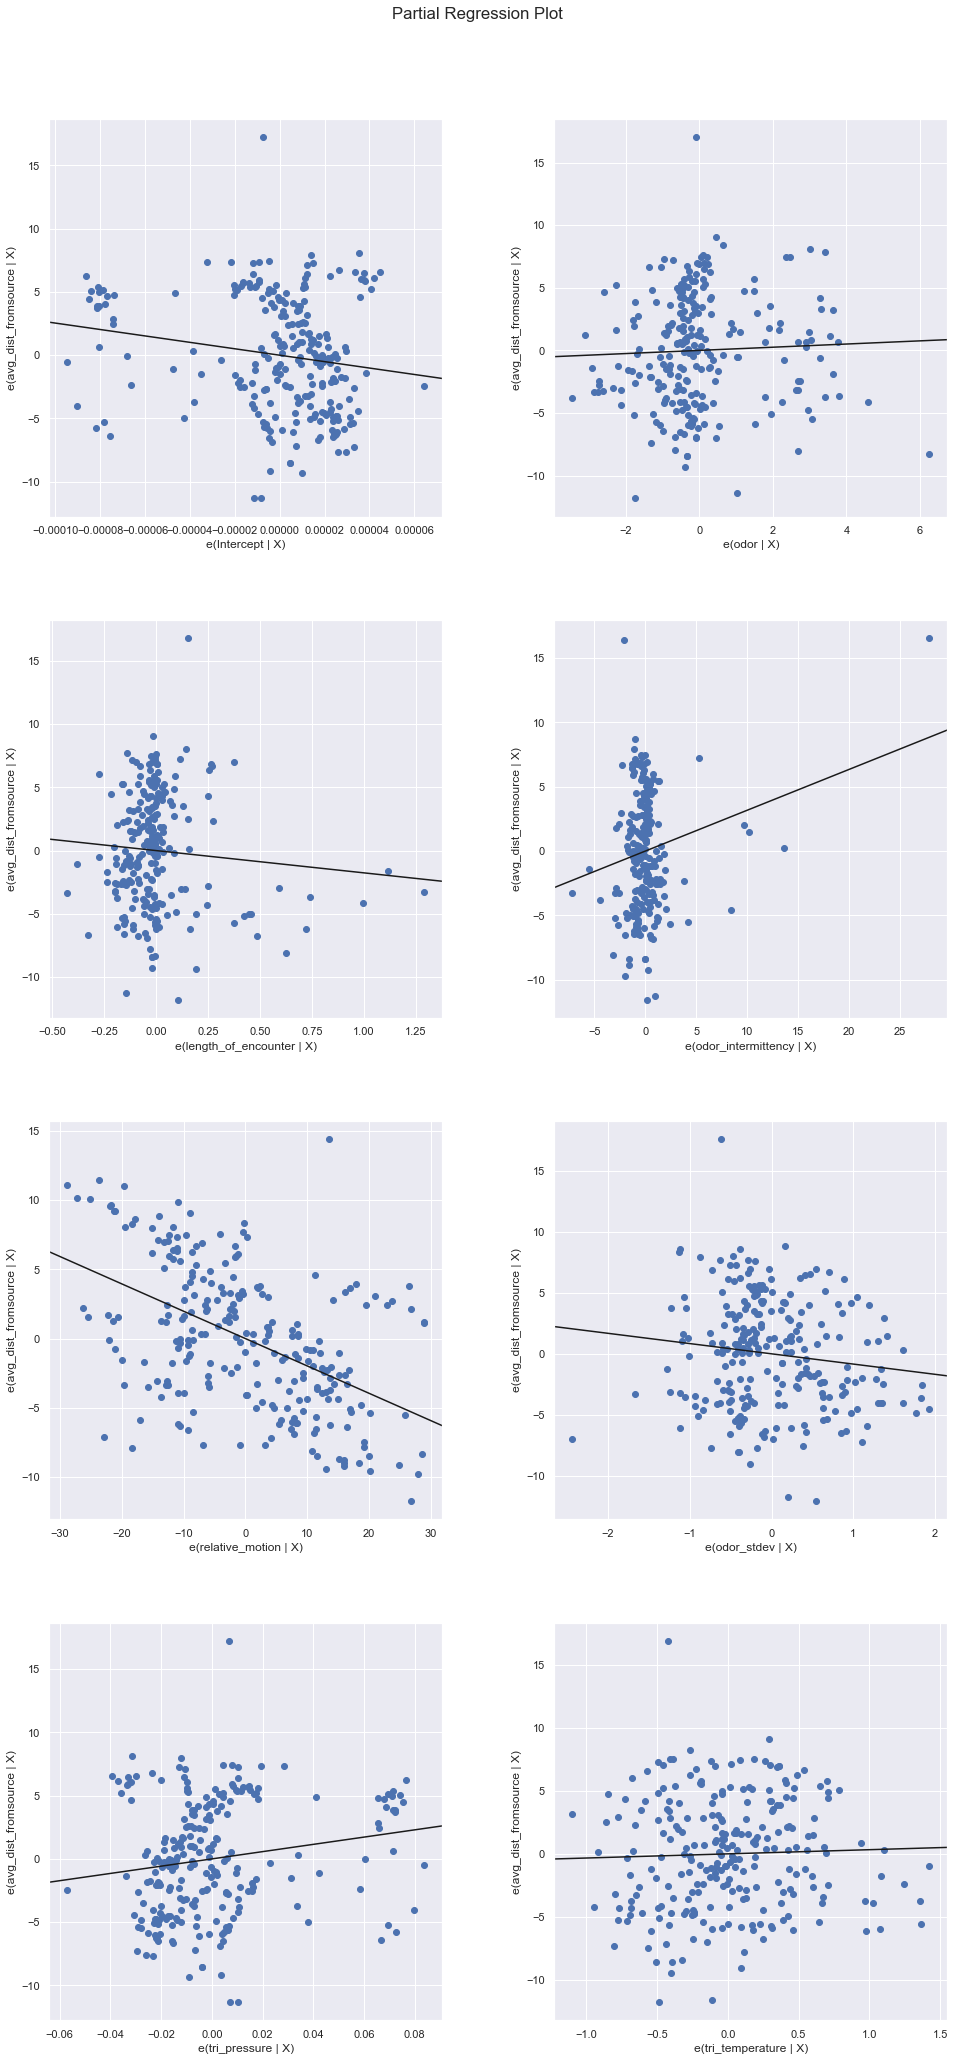

In [20]:
fig = sm.graphics.plot_partregress_grid(odor_distance_model)
fig.tight_layout(pad=5.0)
# fig.savefig('regressplot.jpeg')

### Finding odor encounter distance from source

In [ ]:
# df_pos['time'] = df_tmp['time']
# df_pos['distance']=hp.haversine_distance(df_tmp._ublox_gps_fix_latitude.astype(float),df_tmp._ublox_gps_fix_longitude.astype(float), 39.67650835454546,-119.82060767454543)
# df_pos['odor_concentration'] = df_tmp['_analog_output_data']